# Embedding WikiSection data
This notebook shows how to embed and store WikiSection sentences as `networkx`graph objects

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import json
import numpy as np
import os

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
model.max_seq_length = 512

In [4]:
train = "/dfs/scratch1/gmachi/datasets/WikiSection/wikisection_en_disease_train.json"
with open(train, 'r') as f:
    train_data = json.load(f)

save_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/"
save_path_Zs = os.path.join(save_path, "train")

In [5]:
target = "disease.genetics"  # class-1
# good ones: mechanism, genetics, prevention, prognosis
# bad ones: treatment, symptom

check for prevalence

In [6]:
from utils import process_sentences

In [52]:
# doc_labs = {}
# sal_count = 0
# for i in range(len(train_data)):
#     text = train_data[i]["text"]
#     annots = train_data[i]["annotations"]
#     labs = []

#     for annot in annots:
#         idx = [int(annot["begin"]), int(annot["length"])]
#         pseudo = annot["sectionLabel"]
#         chunk = text[idx[0]:idx[1]]
#         lab = 0
#         if pseudo == target:
#             lab = 1
#         labs.append(lab)
    
#     sal_count += int(np.sum(labs)) # keep count of targets
#     doc_lab = int(np.sum(labs) > 0)
#     # print(np.sum(labs))
#     # print(doc_lab)
#     # print()
#     # if i > 10:
#     #     break
#     doc_labs[i] = doc_lab

In [81]:
doc_labs = {}
sal_count = 0
sent_counts = []
sent_counts_ann = []
for i in range(len(train_data)):
    text = train_data[i]["text"]
    # print(len(text))
    sents = [s for s in text.split(".")]
    sents = process_sentences(sents)
    sent_counts.append(len(sents))

    annots = train_data[i]["annotations"]
    labs = []

    num_sents = 0
    for annot in annots:
        begin = int(annot["begin"])
        idx = [begin, begin+int(annot["length"])]
        # print(idx)
        chunk = text[idx[0]:idx[1]]
        # print(chunk)

        sents = [s for s in chunk.split(".")]
        # print(sents)
        sents = process_sentences(sents)
        ns = len(sents)
        num_sents += ns
        pseudo = [annot["sectionLabel"]] * ns
        # print(pseudo)

        lab = [0] * ns
        if pseudo[0] == target: # if any match
            lab = [1] * ns
        labs.extend(lab)
        
    sent_counts_ann.append(num_sents)
    sal_count += int(np.sum(labs)) # keep count of targets
    doc_lab = int(np.sum(labs) > 0)
    doc_labs[i] = doc_lab

check that last doc has matching numbers of sentences (tokens)

In [82]:
len(labs)

50

In [83]:
num_sents

50

In [84]:
print(sent_counts)
print(sent_counts_ann)

[56, 12, 6, 58, 43, 88, 71, 15, 179, 29, 9, 30, 10, 23, 49, 112, 57, 75, 45, 53, 14, 78, 22, 14, 8, 271, 13, 13, 10, 40, 47, 39, 62, 216, 59, 42, 3, 116, 105, 46, 177, 21, 6, 74, 86, 57, 91, 30, 14, 54, 35, 201, 58, 28, 14, 13, 3, 50, 124, 18, 65, 23, 31, 37, 47, 86, 12, 30, 107, 9, 36, 46, 298, 50, 30, 40, 33, 59, 203, 15, 95, 82, 66, 36, 54, 21, 10, 56, 29, 17, 19, 31, 36, 38, 4, 21, 8, 18, 288, 46, 73, 13, 175, 10, 87, 87, 74, 15, 12, 375, 45, 42, 79, 11, 47, 171, 26, 5, 153, 13, 72, 41, 185, 28, 33, 38, 37, 87, 49, 13, 253, 183, 8, 13, 22, 19, 54, 139, 401, 78, 103, 131, 21, 51, 7, 32, 12, 28, 24, 94, 38, 13, 20, 38, 49, 9, 7, 6, 68, 44, 26, 43, 42, 14, 64, 78, 5, 17, 26, 53, 31, 151, 43, 13, 54, 17, 68, 14, 25, 38, 54, 11, 64, 14, 19, 76, 127, 88, 23, 26, 29, 206, 21, 102, 38, 50, 23, 121, 166, 37, 27, 65, 153, 11, 8, 26, 150, 14, 47, 44, 3, 38, 14, 101, 42, 32, 325, 8, 77, 87, 50, 70, 144, 34, 41, 1, 25, 375, 82, 17, 22, 7, 5, 145, 22, 5, 408, 56, 9, 20, 115, 19, 18, 89, 116, 13,

In [85]:
print("# docs:", len(doc_labs.values()))
print("# salient tokens:", sal_count)

count_0, count_1 = 0, 0
for dv in doc_labs.values():
    if dv == 0:
        count_0 += 1
    else:
        count_1 += 1
print("# class-0:", count_0)
print("# class-1:", count_1)

# docs: 2513
# salient tokens: 3062
# class-0: 2177
# class-1: 336


Note: takes about 20min to run with a single gpu

In [86]:
# section_labs = {}
# section_pseudo = {}
# doc_labs = {}
# for i in range(len(train_data)):
#     text = train_data[i]["text"]
#     annots = train_data[i]["annotations"]
#     labs = []
#     pseudos = []
#     embeds = []

#     for annot in annots:
#         idx = [int(annot["begin"]), int(annot["length"])]
#         chunk = text[idx[0]:idx[1]]
#         embeds.append(model.encode(chunk))
#         pseudo = annot["sectionLabel"]
#         pseudos.append(pseudo)
#         lab = 0
#         if pseudo == target:
#             lab = 1
#         labs.append(lab)
    
#     doc_lab = int(np.sum(labs)) # keep count of targets
#     doc_labs[i] = doc_lab
#     Z = np.stack(embeds)
#     # Z_name = "doc_"+str(i)+"_class_"+str(doc_lab)+".npy"
#     Z_name = "doc_"+str(i)+".npy"

#     save_path_Z = os.path.join(save_path_Zs, Z_name)
#     np.save(save_path_Z, Z)
#     section_pseudo[i] = pseudos
#     section_labs[i] = labs

In [89]:
section_labs = {}
section_pseudo = {}
doc_labs = {}
sal_count = 0
for i in range(len(train_data)):
    text = train_data[i]["text"]
    annots = train_data[i]["annotations"]
    labs = []
    pseudos = []
    embeds = []

    num_sents = 0
    for annot in annots:
        begin = int(annot["begin"])
        idx = [begin, begin+int(annot["length"])]
        chunk = text[idx[0]:idx[1]]
        sents = [s for s in chunk.split(".")]
        sents = process_sentences(sents)
        es = [model.encode(s) for s in sents]
        embeds.extend(es)

        ns = len(sents)
        num_sents += ns
        pseudo = [annot["sectionLabel"]] * ns
        pseudos.extend(pseudo)

        lab = [0] * ns
        if pseudo[0] == target: # if any match
            lab = [1] * ns
        labs.extend(lab)
    
    sal_count += int(np.sum(labs)) # keep count of targets
    doc_lab = int(np.sum(labs) > 0)
    doc_labs[i] = doc_lab
    
    Z = np.stack(embeds)
    Z_name = "doc_"+str(i)+".npy"

    save_path_Z = os.path.join(save_path_Zs, Z_name)
    np.save(save_path_Z, Z)
    section_pseudo[i] = pseudos
    section_labs[i] = labs

In [91]:
print("# docs:", len(doc_labs.values()))
print("# salient tokens:", sal_count)

count_0, count_1 = 0, 0
for dv in doc_labs.values():
    if dv == 0:
        count_0 += 1
    else:
        count_1 += 1
print("# class-0:", count_0)
print("# class-1:", count_1)

# docs: 2513
# salient tokens: 3062
# class-0: 2177
# class-1: 336


In [92]:
from utils import serialize

In [93]:
save_path_doc_labs = os.path.join(save_path, "train-doc-labs.obj")
serialize(doc_labs, save_path_doc_labs)
save_path_sec_pseudo = os.path.join(save_path, "train-sec-pseudo.obj")
serialize(section_pseudo, save_path_sec_pseudo)
save_path_sec_labs = os.path.join(save_path, "train-sec-labs.obj")
serialize(section_labs, save_path_sec_labs)

In [94]:
len(doc_labs)

2513

In [95]:
print("train set:", len(os.listdir(save_path_Zs)))

train set: 2513


# sample embeddings + build map graphs

In [96]:
from utils import convert_text2graph, deserialize
import random
import networkx as nx

In [97]:
save_path_Gs = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs"

We sample 2 embeddings from each training sample to give us ~5k embeddings

In [98]:
embeds_dict = {}
so_dict = {}
embeds_sample = []

save_path_sec_labs = os.path.join(save_path, "train-sec-labs.obj")
sec_lab_dict = deserialize(save_path_sec_labs)
print("train set:", len(os.listdir(save_path_Zs)))

for save_path_Z in os.listdir(save_path_Zs):
    Z_file = os.path.join(save_path_Zs, save_path_Z)
    Z = np.load(Z_file)

    idx = int(save_path_Z.split("_")[1].split(".")[0])

    # sample
    l = Z.shape[0]
    try:
        ids = random.sample(range(l),2)
    except ValueError: #l == 1:
        ids = [0] 
    embeds = [Z[i,:] for i in ids]
    keys = [str(idx) + "_" + str(i) for i in ids]
    for i,k in enumerate(keys):
        embeds_dict[k] = embeds[i] # both loaded into the dict

    embeds_sample.extend(embeds)
    sos = [sec_lab_dict[idx][i] for i in ids]
    for i,k in enumerate(keys):
        so_dict[k] = sos[i] # both loaded into the dict

    # convert to graph
    G = convert_text2graph(Z)
    G_file = save_path_Z.split(".")[0] + "_graph.obj"
    save_path_G = os.path.join(save_path_Gs, G_file)
    serialize(G, save_path_G)

train set: 2513
(57, 384)
(51, 384)
(17, 384)
(59, 384)
(7, 384)
(27, 384)
(178, 384)
(38, 384)
(49, 384)
(4, 384)
(164, 384)
(41, 384)
(13, 384)
(18, 384)
(16, 384)
(16, 384)
(24, 384)
(24, 384)
(3, 384)
(41, 384)
(138, 384)
(119, 384)
(27, 384)
(5, 384)
(5, 384)
(54, 384)
(126, 384)
(79, 384)
(111, 384)
(63, 384)
(23, 384)
(45, 384)
(69, 384)
(86, 384)
(7, 384)
(56, 384)
(4, 384)
(18, 384)
(68, 384)
(14, 384)
(3, 384)
(17, 384)
(23, 384)
(24, 384)
(234, 384)
(12, 384)
(33, 384)
(41, 384)
(7, 384)
(43, 384)
(58, 384)
(15, 384)
(165, 384)
(61, 384)
(20, 384)
(157, 384)
(24, 384)
(95, 384)
(6, 384)
(28, 384)
(76, 384)
(201, 384)
(7, 384)
(22, 384)
(25, 384)
(35, 384)
(106, 384)
(63, 384)
(14, 384)
(89, 384)
(135, 384)
(6, 384)
(8, 384)
(4, 384)
(7, 384)
(15, 384)
(38, 384)
(30, 384)
(14, 384)
(35, 384)
(15, 384)
(15, 384)
(4, 384)
(61, 384)
(7, 384)
(33, 384)
(18, 384)
(16, 384)
(142, 384)
(69, 384)
(78, 384)
(38, 384)
(125, 384)
(1, 384)
(11, 384)
(114, 384)
(37, 384)
(246, 384)
(84, 3

In [99]:
embed_array = np.stack(embeds_sample)
print(embed_array.shape)
save_path_meta = "/dfs/scratch1/gmachi/datasets/wikisection_processed"
save_path_embed = os.path.join(save_path_meta, "embed_sample.obj")
serialize(embed_array, save_path_embed)
save_path_edict = os.path.join(save_path_meta, "embed_dict.obj")
serialize(embeds_dict, save_path_edict)



(5000, 384)


In [100]:
save_path_sos = os.path.join(save_path, "train-sos.obj")
serialize(so_dict, save_path_sos)

In [58]:
# so_dict

In [57]:
# embeds_dict

Confirm topology!

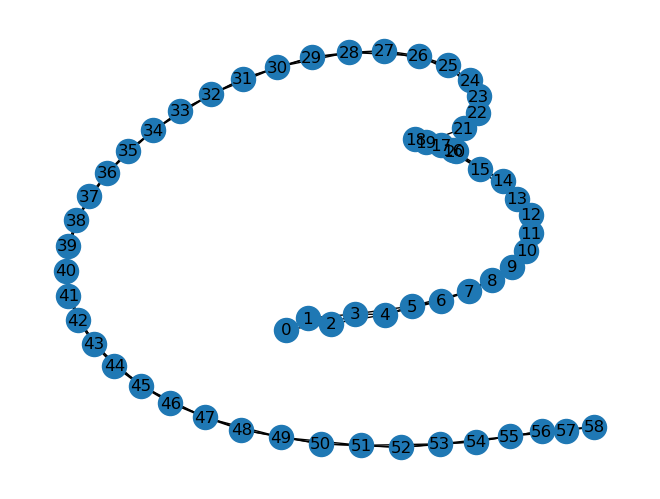

In [102]:
G_saved = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs/doc_1107_graph.obj"
G = deserialize(G_saved)
nx.draw(G, with_labels = True)

In [3]:
save_path_Gs = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs"
print("train set:", len(os.listdir(save_path_Gs)))


train set: 2513


# make training ground truths

In [34]:
from utils import convert_text2graph_gt, deserialize, serialize
import os
import numpy as np
import pdb

gt_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-sec-labs.obj"
gt_dict = deserialize(gt_path)
gt_save_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_gts"

for G_file in os.listdir(save_path_Gs):
    G = os.path.join(save_path_Gs, G_file)
    G = deserialize(G)

    idx = int(G_file.split("_")[1])
    gt_arr = np.array(gt_dict[idx])
    gt = convert_text2graph_gt(gt_arr, G)

    new_name = "doc_"+str(idx)+"_gt.obj"
    gt_dir = os.path.join(gt_save_dir, new_name)
    serialize(gt, gt_dir)

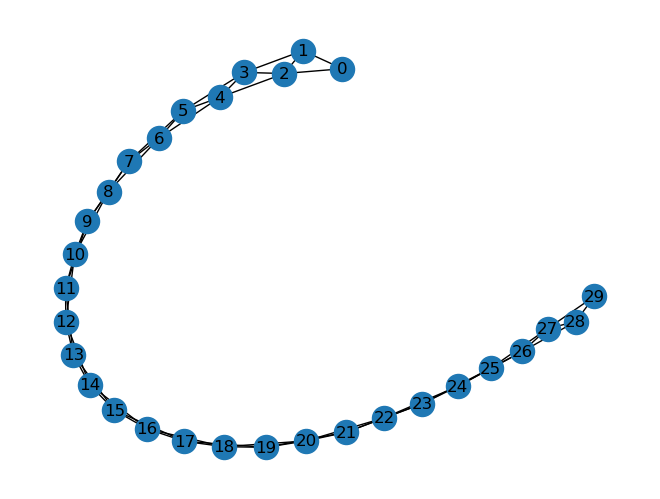

In [35]:
import networkx as nx 
nx.draw(gt, with_labels = True)


In [41]:
gt_directory = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_gts"
doc_lab = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj"
lab_dict = deserialize(doc_lab)

# for gt in os.listdir(gt_directory):
#     idx = int(gt.split("_")[1])
#     gt = os.path.join(gt_directory, gt)
#     gt = deserialize(gt)
#     y = lab_dict[idx]
#     num_sal = np.sum(list(nx.get_node_attributes(gt, "emb").values()))
#     print(y, num_sal)



0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 6
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 29
0 0
0 0
0 0
1 2
0 0
0 0
0 0
1 9
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 3
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 6
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 10
0 0
0 0
0 0
1 18
0 0
0 0
0 0
1 3
0 0
0 0
0 0
0 0
0 0
1 24
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 3
0 0
0 0
0 0
0 0
0 0
1 6
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 5
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 6
0 0
0 0
1 2
0 0
0 0
1 29
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 5
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 8
0 0
0 0
1 4
0 0
0 0
1 9
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
1 4
0 0
1 16
0 0
0 0
0 0
0 0
1 8
0 0
0 0
1 12
0 0
0 0
1 7
0

# repeat for test

In [42]:
test = "/dfs/scratch1/gmachi/datasets/WikiSection/wikisection_en_disease_test.json"
with open(test, 'r') as f:
    test_data = json.load(f)

save_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/"
save_path_Zs = os.path.join(save_path, "test")

In [43]:
target = "disease.genetics"  # class-1
from utils import process_sentences

In [46]:
doc_labs = {}
sal_count = 0
sent_counts = []
sent_counts_ann = []
for i in range(len(test_data)):
    text = test_data[i]["text"]
    # print(len(text))
    sents = [s for s in text.split(".")]
    sents = process_sentences(sents)
    sent_counts.append(len(sents))

    annots = test_data[i]["annotations"]
    labs = []

    num_sents = 0
    for annot in annots:
        begin = int(annot["begin"])
        idx = [begin, begin+int(annot["length"])]
        # print(idx)
        chunk = text[idx[0]:idx[1]]
        # print(chunk)

        sents = [s for s in chunk.split(".")]
        # print(sents)
        sents = process_sentences(sents)
        ns = len(sents)
        num_sents += ns
        pseudo = [annot["sectionLabel"]] * ns
        # print(pseudo)

        lab = [0] * ns
        if pseudo[0] == target: # if any match
            lab = [1] * ns
        labs.extend(lab)
        
    sent_counts_ann.append(num_sents)
    sal_count += int(np.sum(labs)) # keep count of targets
    doc_lab = int(np.sum(labs) > 0)
    doc_labs[i] = doc_lab

In [47]:
print("# docs:", len(doc_labs.values()))
print("# salient tokens:", sal_count)

count_0, count_1 = 0, 0
for dv in doc_labs.values():
    if dv == 0:
        count_0 += 1
    else:
        count_1 += 1
print("# class-0:", count_0)
print("# class-1:", count_1)

# docs: 718
# salient tokens: 925
# class-0: 620
# class-1: 98


In [52]:
section_labs = {}
section_pseudo = {}
doc_labs = {}
sal_count = 0
for i in range(len(test_data)):
    text = test_data[i]["text"]
    annots = test_data[i]["annotations"]
    labs = []
    pseudos = []
    embeds = []

    num_sents = 0
    for annot in annots:
        begin = int(annot["begin"])
        idx = [begin, begin+int(annot["length"])]
        chunk = text[idx[0]:idx[1]]
        sents = [s for s in chunk.split(".")]
        sents = process_sentences(sents)
        es = [model.encode(s) for s in sents]
        embeds.extend(es)

        ns = len(sents)
        num_sents += ns
        pseudo = [annot["sectionLabel"]] * ns
        pseudos.extend(pseudo)

        lab = [0] * ns
        if pseudo[0] == target: # if any match
            lab = [1] * ns
        labs.extend(lab)
    
    sal_count += int(np.sum(labs)) # keep count of targets
    doc_lab = int(np.sum(labs) > 0)
    doc_labs[i] = doc_lab
    
    Z = np.stack(embeds)
    Z_name = "doc_"+str(i)+".npy"

    save_path_Z = os.path.join(save_path_Zs, Z_name)
    np.save(save_path_Z, Z)
    section_pseudo[i] = pseudos
    section_labs[i] = labs

In [53]:
print("# docs:", len(doc_labs.values()))
print("# salient tokens:", sal_count)

count_0, count_1 = 0, 0
for dv in doc_labs.values():
    if dv == 0:
        count_0 += 1
    else:
        count_1 += 1
print("# class-0:", count_0)
print("# class-1:", count_1)

# docs: 718
# salient tokens: 925
# class-0: 620
# class-1: 98


In [54]:
from utils import serialize

In [55]:
save_path_doc_labs = os.path.join(save_path, "test-doc-labs.obj")
serialize(doc_labs, save_path_doc_labs)
save_path_sec_pseudo = os.path.join(save_path, "test-sec-pseudo.obj")
serialize(section_pseudo, save_path_sec_pseudo)
save_path_sec_labs = os.path.join(save_path, "test-sec-labs.obj")
serialize(section_labs, save_path_sec_labs)

In [56]:
print(len(doc_labs))
print("test set:", len(os.listdir(save_path_Zs)))

718
test set: 718


sample embeddings and make map graphs

In [59]:
from utils import convert_text2graph, deserialize
import random
import networkx as nx
save_path_Gs = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_Gs"

In [60]:
embeds_dict = {}
so_dict = {}
embeds_sample = []

save_path_sec_labs = os.path.join(save_path, "test-sec-labs.obj")
sec_lab_dict = deserialize(save_path_sec_labs)
print("test set:", len(os.listdir(save_path_Zs)))

for save_path_Z in os.listdir(save_path_Zs):
    Z_file = os.path.join(save_path_Zs, save_path_Z)
    Z = np.load(Z_file)

    idx = int(save_path_Z.split("_")[1].split(".")[0])

    # sample
    l = Z.shape[0]
    try:
        ids = random.sample(range(l),2)
    except ValueError: #l == 1:
        ids = [0] 
    embeds = [Z[i,:] for i in ids]
    keys = [str(idx) + "_" + str(i) for i in ids]
    for i,k in enumerate(keys):
        embeds_dict[k] = embeds[i] # both loaded into the dict

    embeds_sample.extend(embeds)
    sos = [sec_lab_dict[idx][i] for i in ids]
    for i,k in enumerate(keys):
        so_dict[k] = sos[i] # both loaded into the dict

    # convert to graph
    G = convert_text2graph(Z)
    G_file = save_path_Z.split(".")[0] + "_graph.obj"
    save_path_G = os.path.join(save_path_Gs, G_file)
    serialize(G, save_path_G)

test set: 718


In [61]:
embed_array = np.stack(embeds_sample)
print(embed_array.shape)
save_path_meta = "/dfs/scratch1/gmachi/datasets/wikisection_processed"
save_path_embed = os.path.join(save_path_meta, "embed_sample_test.obj")
serialize(embed_array, save_path_embed)
save_path_edict = os.path.join(save_path_meta, "embed_dict_test.obj")
serialize(embeds_dict, save_path_edict)

(1429, 384)


In [62]:
save_path_sos = os.path.join(save_path, "test-sos.obj")
serialize(so_dict, save_path_sos)

ground truths too

In [63]:
from utils import convert_text2graph_gt, deserialize, serialize
import os
import numpy as np
import pdb

gt_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test-sec-labs.obj"
gt_dict = deserialize(gt_path)
gt_save_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts"

for G_file in os.listdir(save_path_Gs):
    G = os.path.join(save_path_Gs, G_file)
    G = deserialize(G)

    idx = int(G_file.split("_")[1])
    gt_arr = np.array(gt_dict[idx])
    gt = convert_text2graph_gt(gt_arr, G)

    new_name = "doc_"+str(idx)+"_gt.obj"
    gt_dir = os.path.join(gt_save_dir, new_name)
    serialize(gt, gt_dir)

### create a smaller training subset?
- sample files from dir (1/2)
- also then sample embeddings from that new subset 

Check number of nodes for GTs

In [4]:
import os
from utils import deserialize

test_gts = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts"

Matplotlib created a temporary cache directory at /tmp/matplotlib-4yj9_i86 because the default path (/afs/cs.stanford.edu/u/gmachi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
num_nodes = []
for G_file in os.listdir(test_gts):
    G = os.path.join(test_gts, G_file)
    G = deserialize(G)
    num_nodes.append(G.number_of_nodes())


(array([442., 154.,  64.,  36.,   8.,   6.,   3.,   1.,   3.,   1.]),
 array([  1. ,  50.1,  99.2, 148.3, 197.4, 246.5, 295.6, 344.7, 393.8,
        442.9, 492. ]),
 <BarContainer object of 10 artists>)

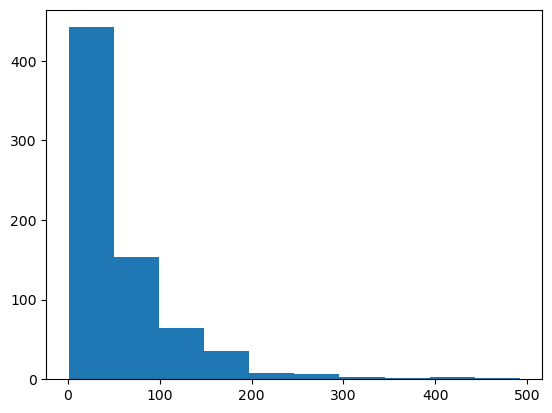

In [6]:
import matplotlib.pyplot as plt
plt.hist(num_nodes)

In [28]:
G = "/dfs/scratch1/gmachi/datasets/wikisection_processed/mlp_Gs/doc_1_graph.obj"
test_gt = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts/doc_1_gt.obj"

In [29]:
from utils import deserialize
G = deserialize(G)
G.number_of_nodes()

62

In [30]:
print(G.nodes[0])

{'pos': 0, 'emb': 1.88693301579595e-07}


In [17]:
G = deserialize(test_gt)
G.number_of_nodes()

62